In [1]:
import sys
import numpy as np
import xarray as xr
import seaborn as sns
import scipy.special as sp
from scipy import interpolate
import matplotlib.pyplot as plt
from SALib.analyze import sobol
from SALib.sample import saltelli
from scipy.stats import distributions as dists 

sys.path.append('../../src/thermal')

from utils import *
import open as nc_open

In [2]:
# file paths to input data
t_fp  = '../../input_data/mass_balance/KMR_MB_k_2_s_2500_knots.dat'
c_fp  = '../../input_data/mass_balance/KMR_MB_k_2_s_2500_coefs.dat'
zs_fp = '../../input_data/topography/glc1-a_surf.dat'

In [3]:
δb = -1.000

z  = np.loadtxt(zs_fp)[:,1]
t  = np.loadtxt(t_fp)
c  = np.loadtxt(c_fp)
mb = interpolate.splev(z, (t,c,2)) + δb

# initalise the classes with default parameter values
AirTemp  = surface_AirTemp()
HeatPump = heat_pump(r_frac = 0.3, 
                     f_dd   = 0.003,
                     h_aq   = 3.0
                     )


xarrays = []

for T_ma in np.linspace(-9.02, -4.0): 
    AirTemp  = surface_AirTemp()
    ds = HeatPump(z, mb, AirTemp, airtemp_kwarg=dict(T_mean=T_ma, T_σ=[0.0]))
    ds = ds.expand_dims("T_ma").assign_coords(T_ma=("T_ma", [T_ma]))
    xarrays.append(ds)
    
result = xr.concat(xarrays, 'T_ma')

Text(0.5, 0, '$\\bar{T}$ at $z_{\\rm ref}$ [m a.s.l.]')

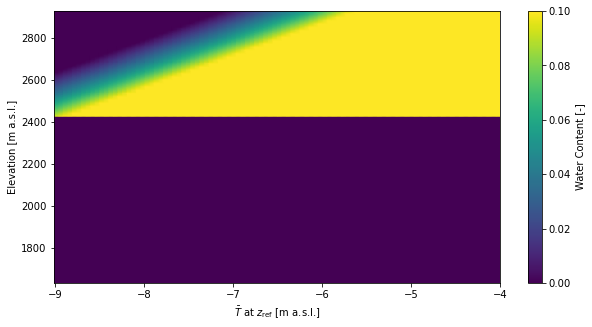

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

im = ax.pcolormesh(result.T_ma, 
                   result.z, 
                   result['Water_Cont.'].isel(time=-1).T, 
                   shading='gouraud')

fig.colorbar(im, label='Water Content [-]')

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel(r'$\bar{T}$ at $z_{\rm ref}$ [m a.s.l.]')

# fig.savefig('./figs/heatpump.png', bbox_inches='tight', facecolor='w', dpi=300)

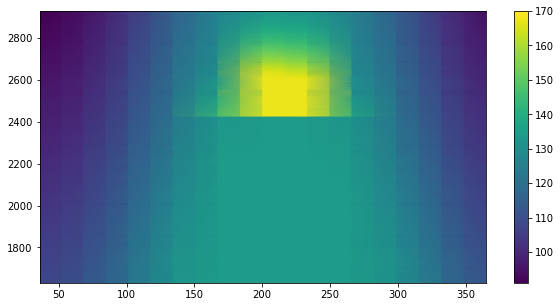

In [9]:
NT     = 11
dt_y   = 0.1
dt_doy = int(dt_y * 365)

fig, ax = plt.subplots(figsize=(10,5))

cmap  = plt.cm.plasma
s_map = plt.cm.ScalarMappable(cmap=cmap)

xarrays = [] 

for doy_i in np.linspace(0,365-dt_doy, NT, dtype=int):
    
    ds = HeatPump(z, mb, AirTemp, doy_i=doy_i, dt=dt_doy, airtemp_kwarg=dict(T_mean=-6.02))
        
    xarrays.append(ds)    

result = xr.concat(xarrays, 'time') 


im = ax.pcolormesh(result.time, 
                   result.z, 
                   result['Enthalpy'].T/1e3, 
                   vmax=170,
                   clim=(None, 170),
                   shading='gouraud')

fig.colorbar(im)


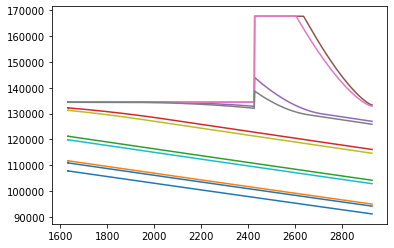

In [10]:
for t in result.time: 
    
    plt.plot(result.z, result['Enthalpy'].sel(time=t))

## Sobol Sensitivities 

In [14]:
distributions = {
     'h_aq'  : dists.uniform(loc=1, scale=10), 
     'f_dd'  : dists.truncnorm(a=-4.15/1.5, b=10, loc=4.1, scale=1.5), 
     'r_frac': dists.gamma(   a=2.5, scale=0.1), 
     'T_ma'  : dists.uniform(loc=-9, scale=5)
    }

units = {
     'h_aq'  : '[m]',
     'f_dd'  : '[mm K$^{-1}$ d$^{-1}$]',
     'r_frac': '[-]', 
     'T_ma'  : '[C]'
    }

problem = {
    'num_vars' : len(distributions), 
    'names'    : distributions.keys(), 
    'bounds'   : [[0,1]] * len(distributions)
}

n_samples = 3000

In [15]:
# Generate uniform samples 
unif_samples = saltelli.sample(problem, n_samples, seed=12345678)

# Empty array to hold transformed variables 
dist_samples = np.zeros_like(unif_samples)

# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(distributions): 
    dist_samples[:,i] = distributions[key].ppf(unif_samples[:,i])

In [16]:
δb = -1.000

z  = np.linspace(2e3,3e3,1001)
t  = np.loadtxt(t_fp)
c  = np.loadtxt(c_fp)
mb = interpolate.splev(z, (t,c,2)) + δb

result = np.empty((n_samples, 1001))

for sample in np.arange(n_samples): 
    
    h_aq, f_dd, r_frac, T_ma = dist_samples[sample]
    
    
    # initalise the classes with default parameter values
    AirTemp  = surface_AirTemp(T_mean=T_ma)
    
    HeatPump = heat_pump(r_frac = r_frac, 
                         f_dd   = f_dd/1e3,
                         h_aq   = h_aq, 
                         w_max_aq=0.1)
        
    ds = HeatPump(z, mb, AirTemp)
    
    result[sample] = ds['Enthalpy'].isel(time=-1)

In [17]:
sobol_indices = [sobol.analyze(problem, Y, seed=12345678) for Y in result.T]

In [18]:
S1s = np.array([s['S1'] for s in sobol_indices])
STs = np.array([s['ST'] for s in sobol_indices])

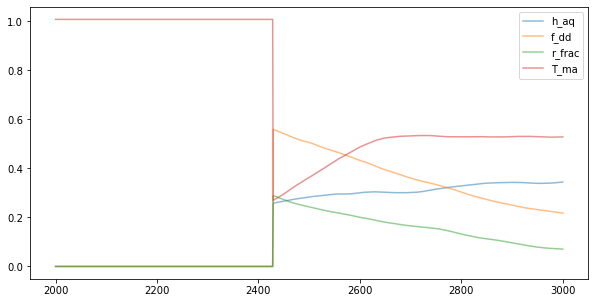

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

for i, key in enumerate(distributions): 
    plt.plot(z, STs[:,i], label=key, alpha=0.5)
    
plt.legend()

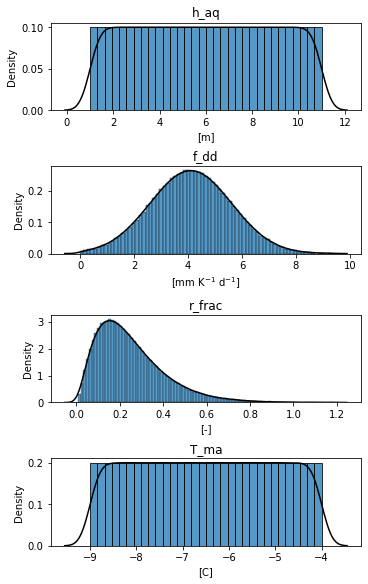

In [20]:
fig, ax = plt.subplots(len(distributions), 1,
                       figsize=(5,8),
                       constrained_layout=True)

for i, key in enumerate(distributions): 
    sns.histplot(dist_samples[:,i], ax=ax[i], stat='density')
    sns.kdeplot(dist_samples[:,i], color='k', ax=ax[i])
    
    
    ax[i].set_title(key)
    ax[i].set_xlabel(units[key])
    

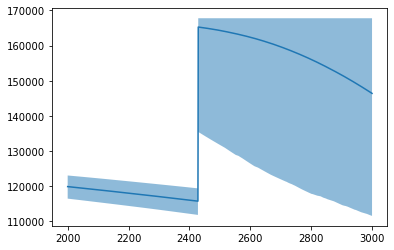

In [21]:
plt.plot(z, result.mean(0))
plt.fill_between(z, 
                 np.percentile(result, 50-95/2., axis=0), 
                 np.percentile(result, 50+95/2., axis=0), 
                 alpha=0.5)

## Archived 

In [12]:
# prog_fp = 'glc1-a/nc/glc1-a_dx_50_NT_11_dt_0.1_MB_-1.000_OFF_Tma_-7.02_limit_surf_Cfirn_0.05_prog.nc'
# prog_ds = nc_open.dataset(prog_fp)

# fig, ax = plt.subplots(figsize=(8,3))



# im = ax.pcolormesh(prog_ds.t*365, 
#                    prog_ds.Z.isel(coord_2=-1, t=-1), 
#                    prog_ds['surface_enthalpy'].isel(coord_2=-1).T/1e3, 
#                    vmax=170,
#                    clim=(None, 170),
#                    shading='auto')

# fig.colorbar(im)


In [ ]:
result.time

In [ ]:
diag_fp = 'glc1-a/nc/glc1-a_dx_50_MB_-1.000_OFF_Tma_-7.02_limit_surf_Cfirn_0.05_diag.nc'

with xr.open_dataset(diag_fp) as diag_ds: 
    diag_ds["height"] = xr.where(diag_ds.height <= 10, 0, diag_ds.height)
    diag_ds["Z"]      = diag_ds.zbed + diag_ds.Z * diag_ds.height 
    diag_ds['vel_m']  = np.sqrt(diag_ds['velocity 1']**2 + diag_ds['velocity 2']**2)


In [ ]:
fig, ax = plt.subplots() 

ax.pcolormesh(diag_ds.X, 
              diag_ds.Z.isel(t=-1), 
              diag_ds['temperature'].isel(t=-1), 
              shading='gouraud')

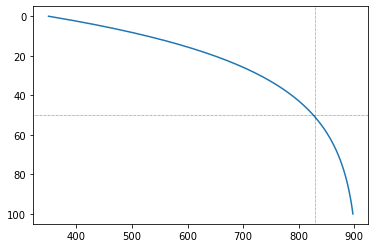

In [13]:
depth = np.linspace(0,100)

ρ_i = 910. 
ρ_s = 350. 
z_t = 50 
z_p = z_t / 1.9
fig, ax = plt.subplots()

ax.plot(ρ_i - (ρ_i - ρ_s)*np.exp(-depth/z_p), depth)

ax.axhline(z_t, c='k', ls=':', lw=0.5)
ax.axvline(830, c='k', ls=':', lw=0.5)
ax.invert_yaxis()

Read the diagnostic file: 

In [ ]:
diag_fp = 'glc1-a/nc/glc1-a_dx_50_MB_-1.5_OFF_limit_surf_Cfirn_0.5_diag.nc'
diag_fp = 'glc1-a/nc/test_diag.nc'

with xr.open_dataset(diag_fp) as diag_ds: 
    diag_ds["height"] = xr.where(diag_ds.height <= 10, 0, diag_ds.height)
    diag_ds["Z"]      = diag_ds.zbed + diag_ds.Z * diag_ds.height 
    diag_ds['vel_m']  = np.sqrt(diag_ds['velocity 1']**2 + diag_ds['velocity 2']**2)

Read the prognostic file: 

In [ ]:
prog_fp = 'glc1-a/nc/glc1-a_dx_50_NT_1000_dt_0.1_MB_-1.000_OFF_Tma_-7.02_limit_surf_Cfirn_0.05_prog.nc'
prog_ds = nc_open.dataset(prog_fp)

In [ ]:
for t in np.arange(0,10): 
    
    subset = prog_ds.isel(coord_2=-1, t=t)
    
    plt.plot(subset.zs, subset['surface_enthalpy'])

In [ ]:
prog_ds.t

In [ ]:
plt.plot(prog_ds.Z.isel(coord_2=-1, t=0), prog_ds.surface_enthalpy.isel(coord_2=-1, t=slice(0,10)).mean('t'))


# plt.plot(prog_ds.Z.isel(coord_2=-1, t=0), prog_ds.surface_enthalpy.isel(coord_2=-1, t=5))

# plt.plot(prog_ds.Z.isel(coord_2=-1, t=0), prog_ds.surface_enthalpy.isel(coord_2=-1, t=6))

# plt.plot(prog_doyi.Z.isel(coord_2=-1, t=0), prog_doyi.surface_enthalpy.isel(coord_2=-1, t=5))

# plt.plot(prog_doyi.Z.isel(coord_2=-1, t=0), prog_doyi.surface_enthalpy.isel(coord_2=-1, t=6))

# plt.plot(prog_ds.Z.isel(coord_2=-1, t=0), prog_ds.surface_enthalpy.isel(coord_2=-1, t=5))

plt.plot(diag_ds.Z.isel(coord_2=-1, t=-1), diag_ds.surface_enthalpy.isel(coord_2=-1, t=-1))

In [ ]:
plt.pcolormesh(diag_ds.X, 
               diag_ds.Z.isel(t=-1), 
               diag_ds.temperature.isel(t=-1), 
               shading='gouraud')

In [ ]:
dists.uniform(loc=0, scale=1).ppf(2)

In [ ]:
x = np.linspace(0, 15, 1000)
plt.plot(x, dists.uniform.pdf(x, loc=1, scale=10))

In [ ]:
x = np.linspace(-1, 8, 1000)
plt.plot(x, dists.truncnorm.pdf(x, a=-4.15/1.5, b=10, loc=4.1, scale=1.5))

In [ ]:
x = np.linspace(-0.1, 1.1, 100)
plt.plot(x, dists.gamma.pdf(x, a=2.5, scale=0.1))

In [ ]:
x = np.linspace(-10, -2, 1000)
plt.plot(x, dists.uniform.pdf(x, loc=-9, scale=5))

In [ ]:
def erf(x): 
    
    def tau(x): 
        t = 1 / (1 + 0.5 * np.abs(x))
        
        return t * np.exp(-x**2             \
                          - 1.26551223      \
                          + 1.00002368*t    \
                          + 0.37409196*t**2 \
                          + 0.09678418*t**3 \
                          - 0.18628806*t**4 \
                          + 0.27886807*t**5 \
                          - 1.13520398*t**6 \
                          + 1.48851587*t**7 \
                          - 0.82215223*t**8 \
                          + 0.17087277*t**9 )
                          
    return np.where(x >= 0, 1 - tau(x), tau(x) - 1)
    
def erfc(x): 
    return 1 - erf(x)

In [ ]:
x = np.linspace(0,3,1000)

In [ ]:
plt.plot(x, erfc(x))
plt.plot(x, sp.erfc(x))